Target: weekend_study
Features (7): ['ss', 'bad_sleep', 'study_form', 'interest', 'glasses', 'literature', 'anime']


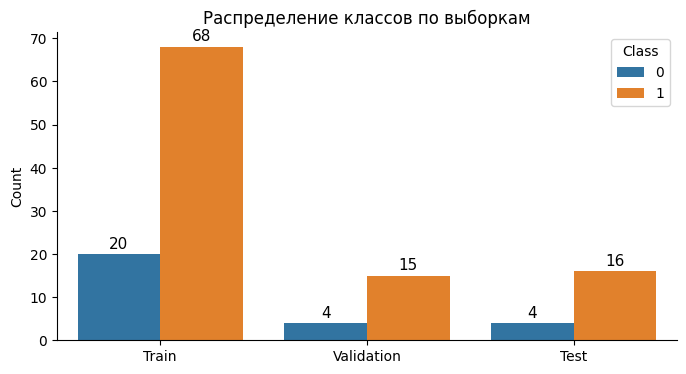

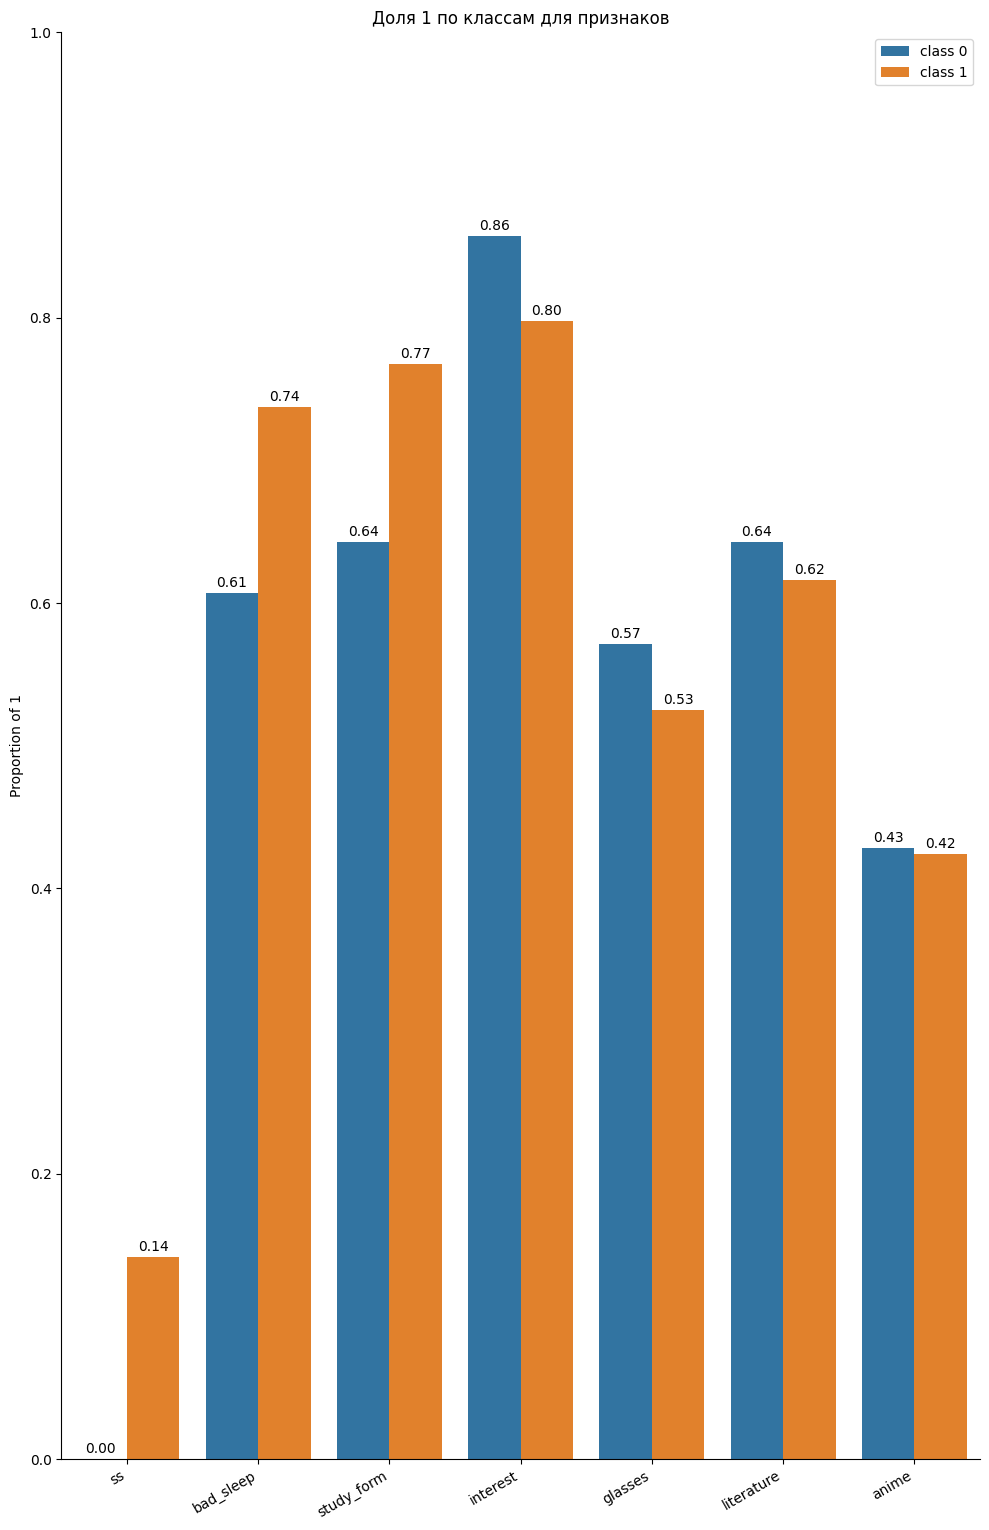

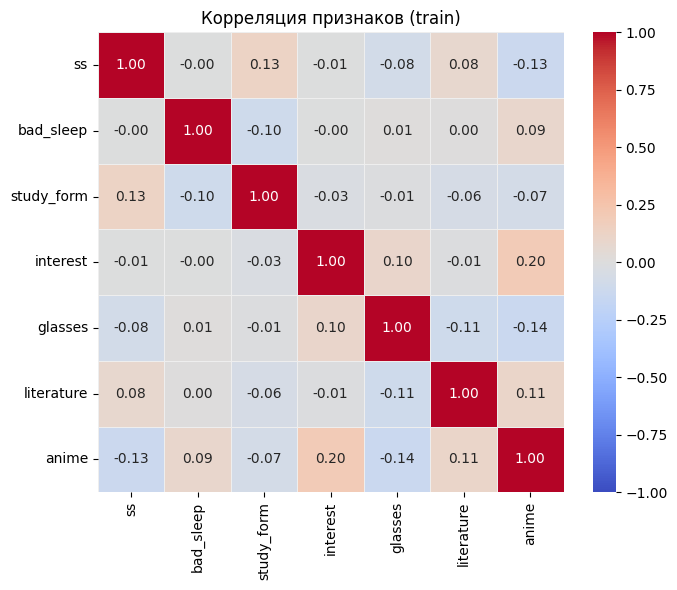

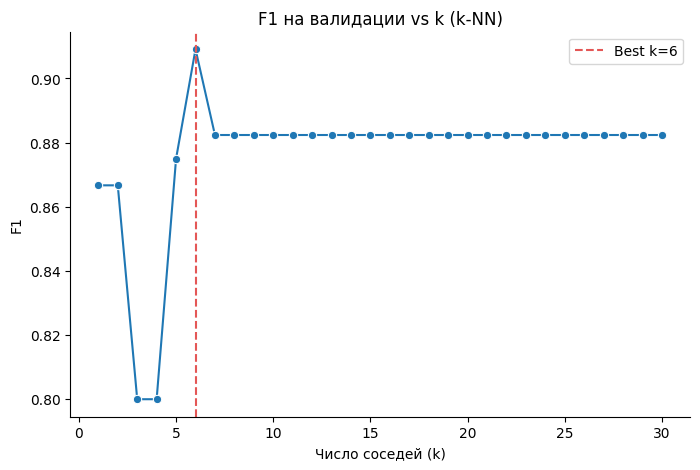

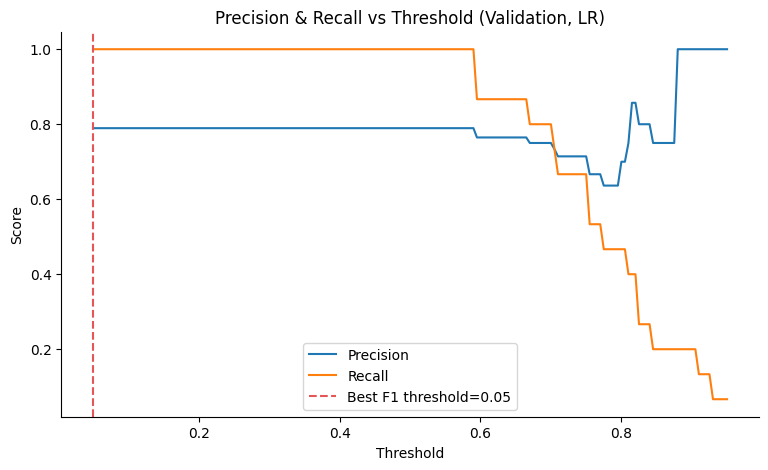

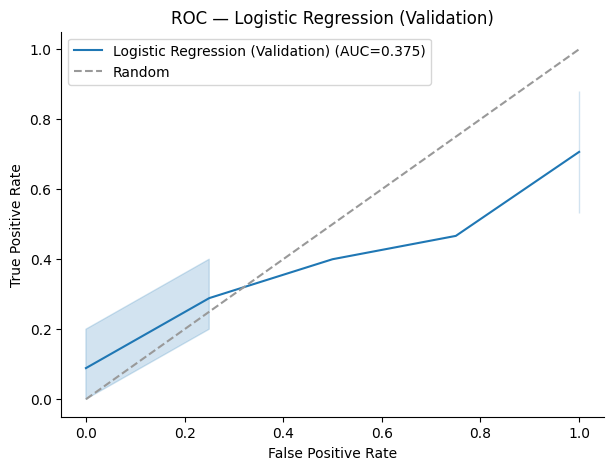

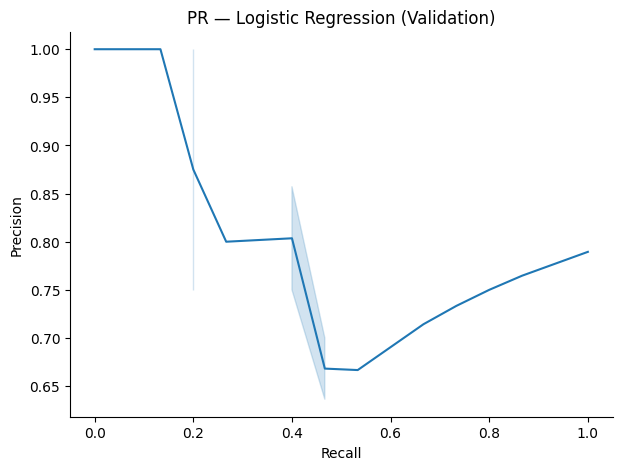

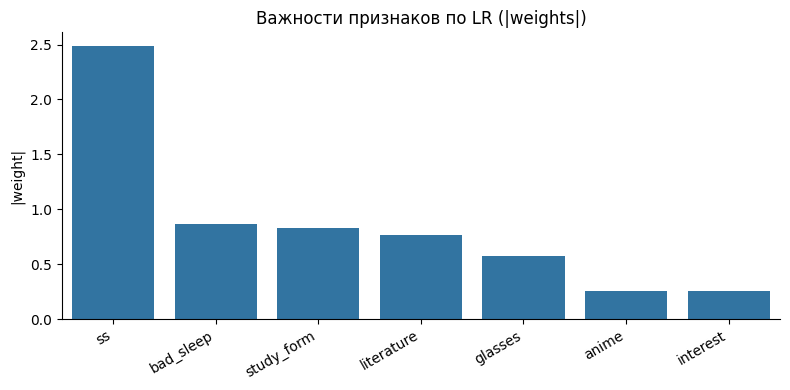

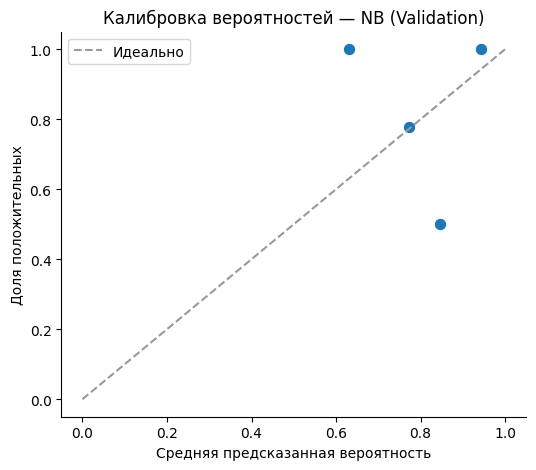

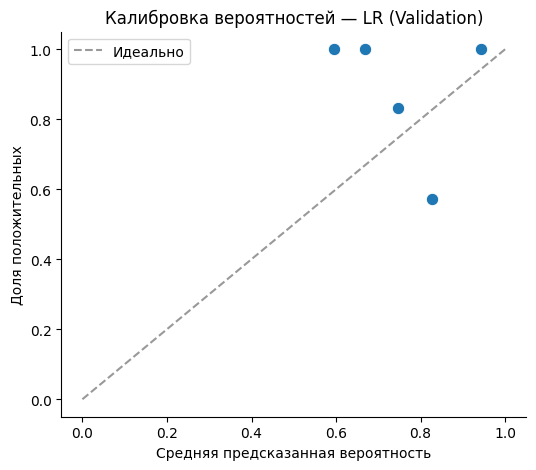


=== Trivial classifier ===
Accuracy: 0.8000
Precision: 0.8000
Recall: 1.0000
F1: 0.8889


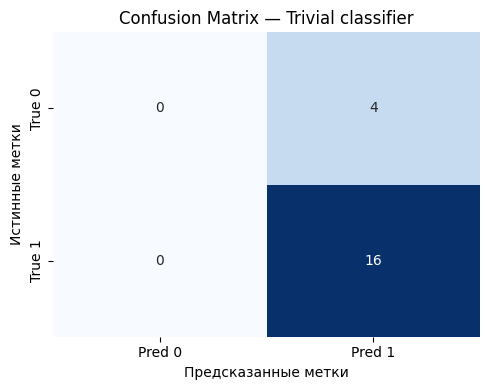


=== Naive Bayes (Bernoulli) ===
Accuracy: 0.8000
Precision: 0.8000
Recall: 1.0000
F1: 0.8889
ROC-AUC: 0.5469


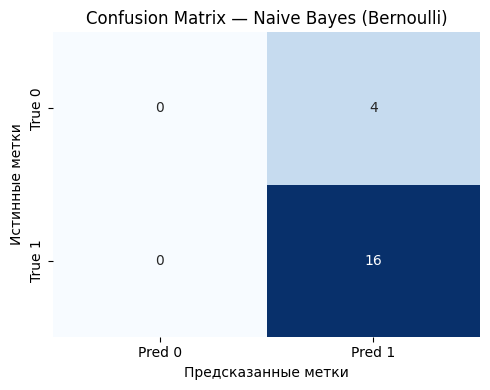

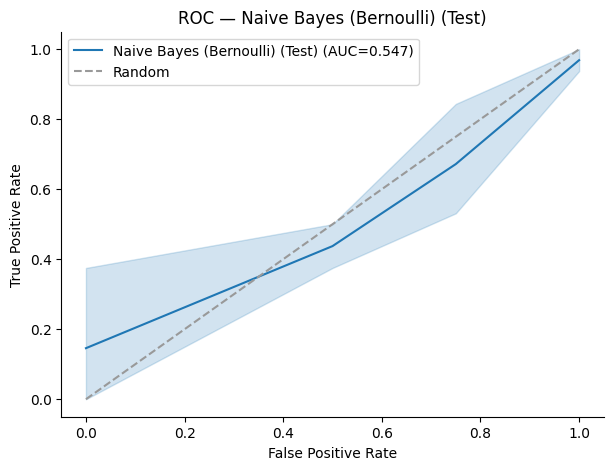

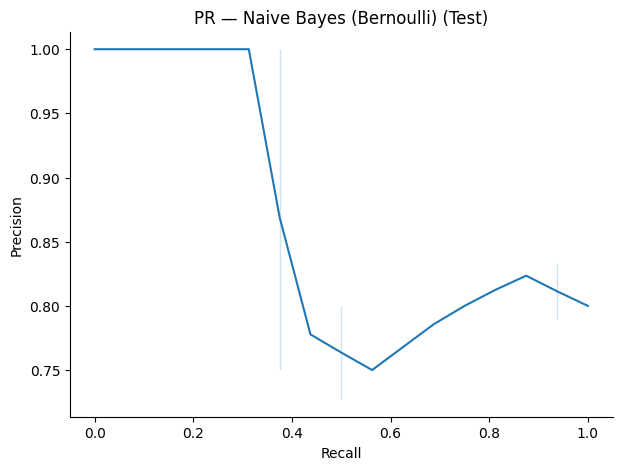


=== k-NN (k=6) ===
Accuracy: 0.8500
Precision: 0.8421
Recall: 1.0000
F1: 0.9143


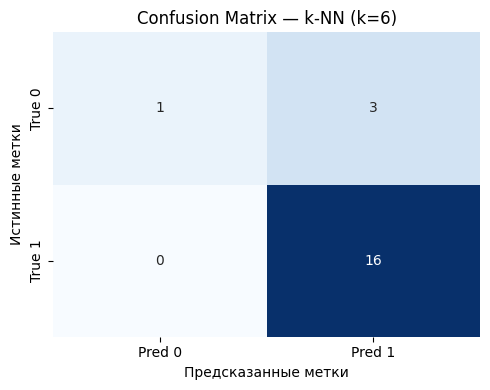


=== Logistic Regression ===
Accuracy: 0.8000
Precision: 0.8000
Recall: 1.0000
F1: 0.8889
ROC-AUC: 0.5312


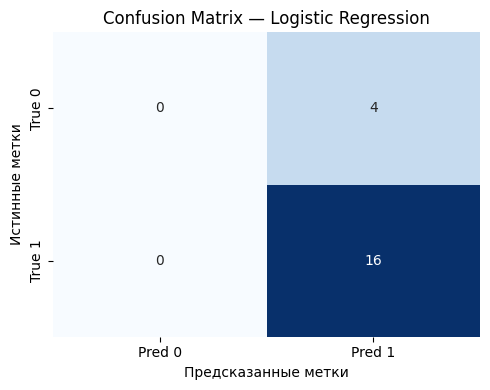

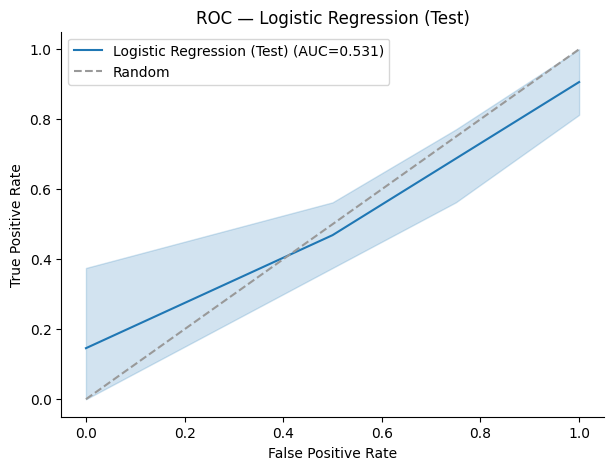

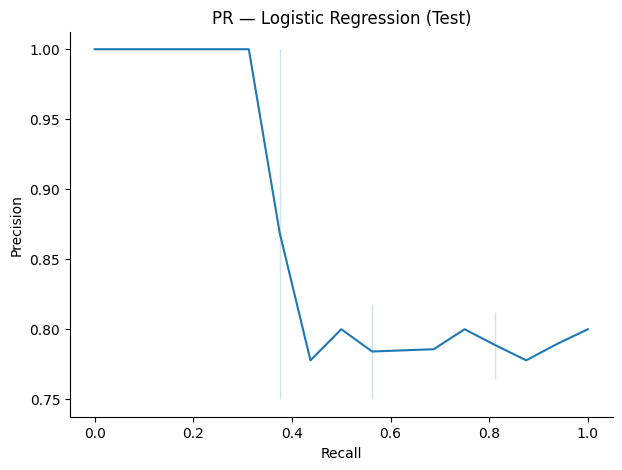

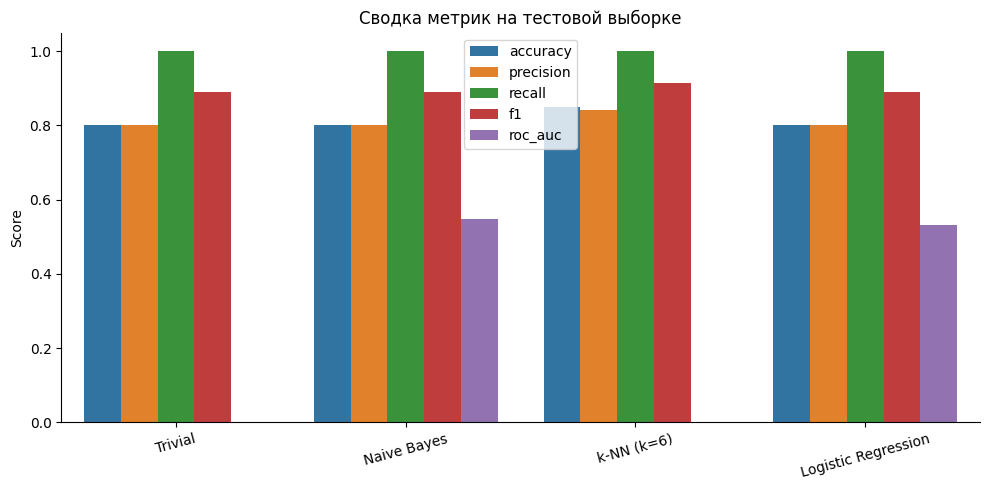

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
)
from sklearn.metrics import mutual_info_score

np.random.seed(42)

df = pd.read_csv('famcs_students.csv')

def to_binary(series):
    return (series == 'Да').astype(int)

df['ss'] = to_binary(df['ss'])
df['weekend_study'] = to_binary(df['weekend_study'])
df['bad_sleep'] = to_binary(df['bad_sleep'])
df['glasses'] = to_binary(df['glasses'])
df['anime'] = to_binary(df['anime'])
df['literature'] = to_binary(df['literature'])
df['study_form'] = (df['study_form'] == 'Бюджет').astype(int)
df['interest'] = (df['interest'] == 'Программирование').astype(int)

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

N = 2
y_col = binary_cols[N % 8]
X_cols_all = [c for c in binary_cols if c != y_col]

mi = {c: mutual_info_score(df[y_col], df[c]) for c in X_cols_all}
corr = {c: abs(np.corrcoef(df[y_col], df[c])[0, 1]) for c in X_cols_all}
ranked = sorted(X_cols_all, key=lambda c: (mi[c] + corr[c]), reverse=True)

X_cols = ranked[:max(5, len(X_cols_all))]
X = df[X_cols].copy()
y = df[y_col].copy()

print(f"Target: {y_col}")
print(f"Features ({len(X_cols)}): {X_cols}")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42, stratify=y_temp
)

def plot_class_distribution(y_train, y_val, y_test):
    df_plot = pd.DataFrame({
        "Split": ["Train"]*len(y_train) + ["Validation"]*len(y_val) + ["Test"]*len(y_test),
        "Class": pd.concat([y_train, y_val, y_test]).astype(int).values
    })
    plt.figure(figsize=(8,4))
    ax = sns.countplot(data=df_plot, x="Split", hue="Class")
    plt.title("Распределение классов по выборкам")
    plt.xlabel("")
    plt.ylabel("Count")
    sns.despine()
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', label_type='edge', padding=2, fontsize=11)
    plt.show()

def plot_feature_distributions(X, y):
    data = []
    for c in X.columns:
        p0 = X[c][y==0].mean()
        p1 = X[c][y==1].mean()
        data.append((c, "class 0", p0))
        data.append((c, "class 1", p1))
    df_plot = pd.DataFrame(data, columns=["feature", "class", "proportion"])
    plt.figure(figsize=(10, 2.2*len(X.columns)))
    ax = sns.barplot(data=df_plot, x="feature", y="proportion", hue="class")
    plt.title("Доля 1 по классам для признаков")
    plt.ylim(0, 1)
    plt.xlabel("")
    plt.ylabel("Proportion of 1")
    plt.xticks(rotation=30, ha='right')
    sns.despine()
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', label_type='edge', padding=2, fontsize=10)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()

def plot_corr_heatmap(X, title="Корреляция признаков"):
    C = np.corrcoef(X.values.T)
    plt.figure(figsize=(7,6))
    sns.heatmap(C, xticklabels=X.columns, yticklabels=X.columns,
                cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f",
                linewidths=0.5, linecolor="#eeeeee")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def reliability_diagram(y_true, y_proba, n_bins=10, title="Reliability diagram"):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    bins = np.linspace(0, 1, n_bins+1)
    centers = 0.5*(bins[1:] + bins[:-1])
    frac_pos, mean_proba = [], []
    for i in range(n_bins):
        mask = (y_proba >= bins[i]) & (y_proba < bins[i+1])
        if mask.sum() > 0:
            frac_pos.append(y_true[mask].mean())
            mean_proba.append(y_proba[mask].mean())
        else:
            frac_pos.append(np.nan)
            mean_proba.append(np.nan)
    plt.figure(figsize=(6,5))
    sns.lineplot(x=[0,1], y=[0,1], color="#999999", linestyle="--", label="Идеально")
    sns.scatterplot(x=mean_proba, y=frac_pos, s=80)
    plt.title(title)
    plt.xlabel("Средняя предсказанная вероятность")
    plt.ylabel("Доля положительных")
    plt.legend()
    sns.despine()
    plt.show()

def plot_confusion_matrix(cm, title="Confusion matrix", labels=("True 0","True 1"), pred_labels=("Pred 0","Pred 1")):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=pred_labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")
    plt.tight_layout()
    plt.show()

def plot_roc_pr(y_true, y_proba, name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    precisions, recalls, _ = precision_recall_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)

    plt.figure(figsize=(7,5))
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC={auc:.3f})")
    sns.lineplot(x=[0,1], y=[0,1], color="#999999", linestyle="--", label="Random")
    plt.title(f"ROC — {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    sns.despine()
    plt.show()

    plt.figure(figsize=(7,5))
    sns.lineplot(x=recalls, y=precisions)
    plt.title(f"PR — {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    sns.despine()
    plt.show()

plot_class_distribution(y_train, y_val, y_test)
plot_feature_distributions(X, y)
plot_corr_heatmap(X_train, title="Корреляция признаков (train)")

most_common_class = Counter(y_train).most_common(1)[0][0]
def trivial_predict(X_):
    return np.full(shape=(X_.shape[0],), fill_value=most_common_class, dtype=int)

class MyBernoulliNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)
        self.classes_, self.class_counts_ = np.unique(y, return_counts=True)
        self.prior_ = self.class_counts_ / len(y)
        self.likelihood_ = {}
        for cls in self.classes_:
            X_cls = X[y == cls]
            self.likelihood_[cls] = (X_cls.sum(axis=0) + self.alpha) / (X_cls.shape[0] + 2*self.alpha)
        return self

    def predict_log_proba(self, X):
        X = np.asarray(X, dtype=float)
        logs = []
        for idx, cls in enumerate(self.classes_):
            p = self.prior_[idx]
            p_feat = self.likelihood_[cls]
            log_p = np.log(p) + np.sum(
                X * np.log(p_feat + 1e-12) + (1 - X) * np.log(1 - p_feat + 1e-12),
                axis=1
            )
            logs.append(log_p)
        return np.vstack(logs).T

    def predict_proba(self, X):
        logp = self.predict_log_proba(X)
        m = logp.max(axis=1, keepdims=True)
        probs = np.exp(logp - m)
        probs = probs / probs.sum(axis=1, keepdims=True)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

nb = MyBernoulliNB(alpha=1.0).fit(X_train.values, y_train.values)
y_pred_nb = nb.predict(X_test.values)
y_prob_nb = nb.predict_proba(X_test.values)[:, 1]

def pairwise_distances(A, b, metric="euclidean"):
    if metric == "euclidean":
        return np.linalg.norm(A - b, axis=1)
    elif metric == "manhattan":
        return np.sum(np.abs(A - b), axis=1)
    else:
        raise ValueError("Unknown metric")

class MyKNN:
    def __init__(self, k=5, metric="euclidean", weighted=False):
        self.k = k
        self.metric = metric
        self.weighted = weighted

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y, dtype=int)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        preds = []
        for x in X:
            d = pairwise_distances(self.X_train, x, metric=self.metric)
            idx = np.argsort(d)[:self.k]
            labels = self.y_train[idx]
            if not self.weighted:
                m = Counter(labels).most_common(1)[0][0]
                preds.append(m)
            else:
                eps = 1e-9
                w = 1.0 / (d[idx] + eps)
                s0 = w[labels == 0].sum()
                s1 = w[labels == 1].sum()
                preds.append(1 if s1 >= s0 else 0)
        return np.array(preds, dtype=int)

ks = range(1, 31)
scores_k = []
best_k, best_f1 = None, -1
for k in ks:
    knn_tmp = MyKNN(k=k, metric="euclidean", weighted=False).fit(X_train.values, y_train.values)
    y_val_pred = knn_tmp.predict(X_val.values)
    f1 = f1_score(y_val.values, y_val_pred, zero_division=0)
    scores_k.append(f1)
    if f1 > best_f1:
        best_f1, best_k = f1, k

plt.figure(figsize=(8,5))
sns.lineplot(x=list(ks), y=scores_k, marker="o")
plt.axvline(best_k, color="#E45756", linestyle="--", label=f"Best k={best_k}")
plt.title("F1 на валидации vs k (k-NN)")
plt.xlabel("Число соседей (k)")
plt.ylabel("F1")
plt.legend()
sns.despine()
plt.show()

knn = MyKNN(k=best_k, metric="euclidean", weighted=False).fit(X_train.values, y_train.values)
y_pred_knn = knn.predict(X_test.values)

class MyLogisticRegression:
    def __init__(self, lr=0.1, n_iters=5000, l2=1e-3, tol=1e-8, early_stop=True, verbose=False):
        self.lr = lr
        self.n_iters = n_iters
        self.l2 = l2
        self.tol = tol
        self.early_stop = early_stop
        self.verbose = verbose

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0.0
        prev_loss = np.inf
        for it in range(self.n_iters):
            z = X @ self.w + self.b
            p = self._sigmoid(z)
            loss = -np.mean(y*np.log(p+1e-12)+(1-y)*np.log(1-p+1e-12)) + 0.5*self.l2*np.dot(self.w, self.w)
            grad_w = (X.T @ (p - y))/n + self.l2*self.w
            grad_b = np.mean(p - y)
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
            if self.verbose and it % 200 == 0:
                print(f"iter={it} loss={loss:.6f}")
            if self.early_stop and abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        z = X @ self.w + self.b
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

lr_model = MyLogisticRegression(lr=0.1, n_iters=5000, l2=1e-3, tol=1e-8, early_stop=True).fit(X_train.values, y_train.values)

y_val_proba = lr_model.predict_proba(X_val.values)
thresholds = np.linspace(0.05, 0.95, 181)
best_thresh, best_f1_val = 0.5, -1
prec_list, rec_list, thr_list = [], [], []
for th in thresholds:
    y_val_pred = (y_val_proba >= th).astype(int)
    prec = precision_score(y_val.values, y_val_pred, zero_division=0)
    rec = recall_score(y_val.values, y_val_pred, zero_division=0)
    f1 = f1_score(y_val.values, y_val_pred, zero_division=0)
    prec_list.append(prec); rec_list.append(rec); thr_list.append(th)
    if f1 > best_f1_val:
        best_f1_val = f1
        best_thresh = th

plt.figure(figsize=(9,5))
sns.lineplot(x=thr_list, y=prec_list, label="Precision")
sns.lineplot(x=thr_list, y=rec_list, label="Recall")
plt.axvline(best_thresh, color="#E45756", linestyle="--", label=f"Best F1 threshold={best_thresh:.2f}")
plt.title("Precision & Recall vs Threshold (Validation, LR)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
sns.despine()
plt.show()

plot_roc_pr(y_val.values, y_val_proba, name="Logistic Regression (Validation)")

imp = pd.Series(np.abs(lr_model.w), index=X_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=imp.index, y=imp.values,)
plt.title("Важности признаков по LR (|weights|)")
plt.ylabel("|weight|")
plt.xlabel("")
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

reliability_diagram(y_val.values, nb.predict_proba(X_val.values)[:,1], title="Калибровка вероятностей — NB (Validation)")
reliability_diagram(y_val.values, y_val_proba, title="Калибровка вероятностей — LR (Validation)")

def evaluate_and_plot(y_true, y_pred, y_proba=None, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    if auc is not None:
        print(f"ROC-AUC: {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, title=f"Confusion Matrix — {model_name}")

    if y_proba is not None:
        plot_roc_pr(y_true, y_proba, name=f"{model_name} (Test)")

y_pred_trivial = trivial_predict(X_test.values)
evaluate_and_plot(y_test.values, y_pred_trivial, y_proba=None, model_name="Trivial classifier")

evaluate_and_plot(y_test.values, y_pred_nb, y_proba=y_prob_nb, model_name="Naive Bayes (Bernoulli)")

evaluate_and_plot(y_test.values, y_pred_knn, y_proba=None, model_name=f"k-NN (k={best_k})")

y_pred_lr = lr_model.predict(X_test.values, threshold=best_thresh)
y_prob_lr = lr_model.predict_proba(X_test.values)
evaluate_and_plot(y_test.values, y_pred_lr, y_proba=y_prob_lr, model_name="Logistic Regression")

results = []
def collect_metrics(name, y_true, y_pred, y_proba=None):
    res = {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    }
    results.append(res)

collect_metrics("Trivial", y_test.values, y_pred_trivial, None)
collect_metrics("Naive Bayes", y_test.values, y_pred_nb, y_prob_nb)
collect_metrics(f"k-NN (k={best_k})", y_test.values, y_pred_knn, None)
collect_metrics("Logistic Regression", y_test.values, y_pred_lr, y_prob_lr)

df_res = pd.DataFrame(results)
df_res_melt = df_res.melt(id_vars="model", var_name="metric", value_name="score")

plt.figure(figsize=(10,5))
sns.barplot(data=df_res_melt, x="model", y="score", hue="metric")
plt.title("Сводка метрик на тестовой выборке")
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=15)
plt.legend(title="")
sns.despine()
plt.tight_layout()
plt.show()
